In [146]:
import numpy as np
import pandas as pd
import seaborn as sns


from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn import metrics
from sklearn.cross_validation import train_test_split

import scipy.stats

import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
    
from sklearn import preprocessing
from sklearn import decomposition

import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import confusion_matrix

In [147]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
            
            
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [148]:
# On crée la fonction pour réaliser les Dendrogram
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [149]:
# Description des données: présentation des variables, caractéristiques des billets vrais/faux,
# corrélations et analyses bivariées (box plot)

# Mission n°0

In [150]:
billets = pd.read_csv('billets.csv', sep=',')
billets = billets.set_index('is_genuine')
billets.head()

,length,height_left,height_right,margin_low,margin_up,diagonal
is_genuine,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83
True,171.67,103.74,103.70,4.01,2.87,113.29
True,171.83,103.76,103.76,4.40,2.88,113.84
True,171.80,103.78,103.65,3.73,3.12,113.63
True,172.05,103.70,103.75,5.04,2.27,113.55


In [151]:
billets_t=billets[(billets.index==True)] #Table des billets vrais
billets_f=billets[(billets.index==False)] #Table des billets faux

In [152]:
summaryT = billets_t.describe()
summaryT = summaryT.transpose()
summaryT.head() # Summary de la table de billet vrais

,count,mean,std,min,25%,50%,75%,max
length,100.0,171.9761,0.307981,171.04,171.7900,172.005,172.1625,172.75
height_left,100.0,103.9515,0.296251,103.23,103.7400,103.915,104.1450,104.86
height_right,100.0,103.7759,0.292406,103.14,103.5575,103.760,103.9725,104.95
margin_low,100.0,4.1435,0.314509,3.54,3.9000,4.080,4.3825,5.04
margin_up,100.0,3.0555,0.197726,2.27,2.9375,3.070,3.1925,3.53


In [153]:
summaryF = billets_f.describe()
summaryF = summaryF.transpose()
summaryF.head() # Summary de la table de billet faux

,count,mean,std,min,25%,50%,75%,max
length,70.0,171.889857,0.297426,171.38,171.6825,171.875,172.0475,173.01
height_left,70.0,104.230429,0.213130,103.78,104.0825,104.215,104.3775,104.72
height_right,70.0,104.145571,0.253152,103.44,103.9825,104.170,104.2800,104.86
margin_low,70.0,5.281571,0.540846,3.82,4.9525,5.265,5.7025,6.28
margin_up,70.0,3.334571,0.185102,2.98,3.1850,3.335,3.4500,3.68


In [154]:
billets_mean=billets.groupby(['is_genuine']).mean().add_suffix('_avg').reset_index()
billets_mean=billets_mean.set_index('is_genuine')
billets_mean.loc['diff T - F']=billets_mean.loc[True]-billets_mean.loc[False]
billets_mean # Table avec la moyenne pour chaque variable pour les billets vrais et pour les billets faux

,length_avg,height_left_avg,height_right_avg,margin_low_avg,margin_up_avg,diagonal_avg
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200
diff T - F,0.086243,-0.278929,-0.369671,-1.138071,-0.279071,1.546486


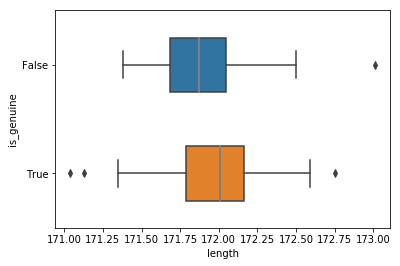

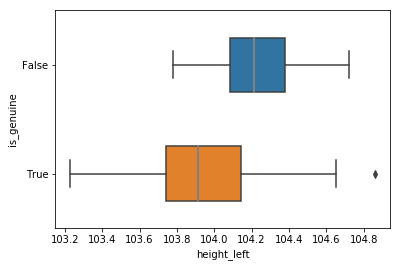

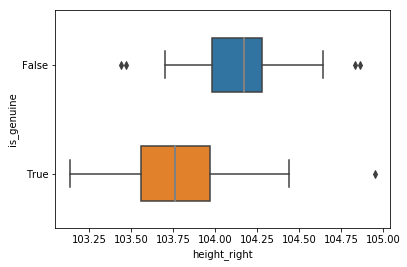

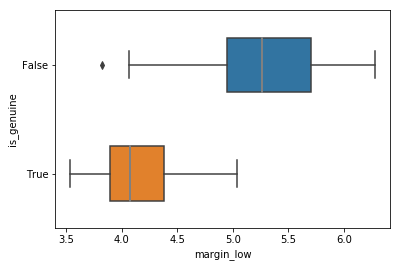

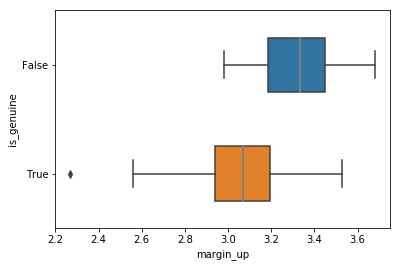

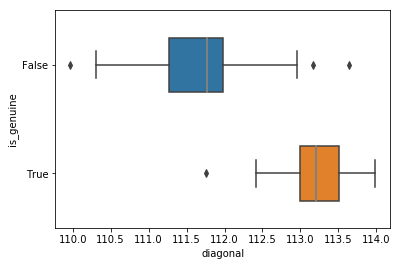

In [155]:
medianprops = dict(linewidth=2, color='grey')
#medianprops = {"linestyle": '-.', 'color': 'red'}

for variable in billets.columns:
    sns_plot=sns.boxplot(
        x = billets[variable], 
        y = billets.index,
        orient = "h",
        medianprops = medianprops,
        width = .5)
    plt.show()
    sns_plot.get_figure().savefig("{}".format(variable)+"_boxplot.png")

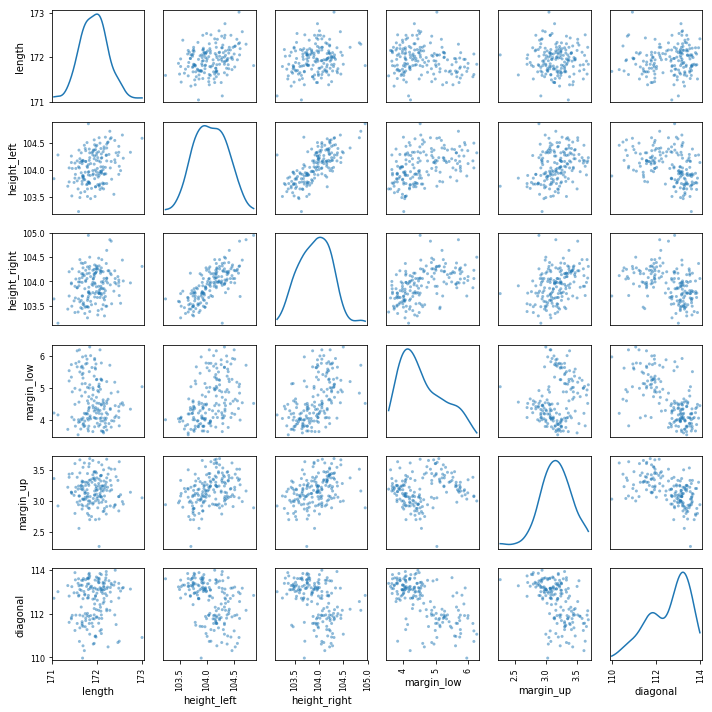

In [156]:
# On regarde la distribution de chaque variable, et les interactions deux à deux
pd.plotting.scatter_matrix(billets.loc[:, "length":"diagonal"], diagonal="kde",
                           figsize=(10,10))

plt.tight_layout()
plt.savefig("scatter_matrix.png")
plt.show()

# Mission n°1

# ACP sur la data brute

In [157]:
# Pour l'ACP, il faut bien que tu analyses les valeurs propres
# que tu regardes les dimensions qui peuvent être intéressantes
# Si tu dois montrer les plans factoriels des différentes représentations et dire quelle représentation est la meilleure
# Le co2 (qualité de représentation va t'aider)

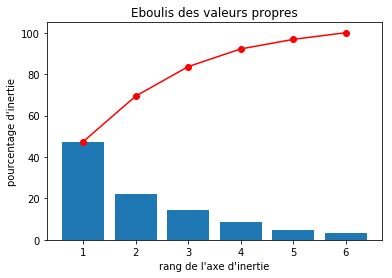

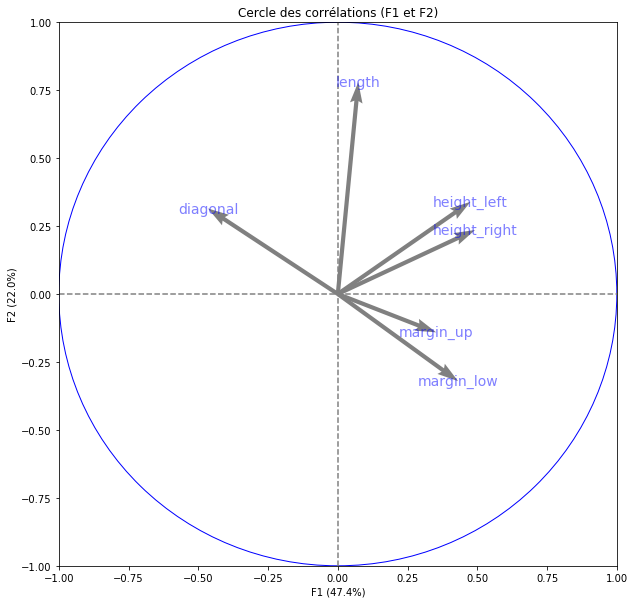

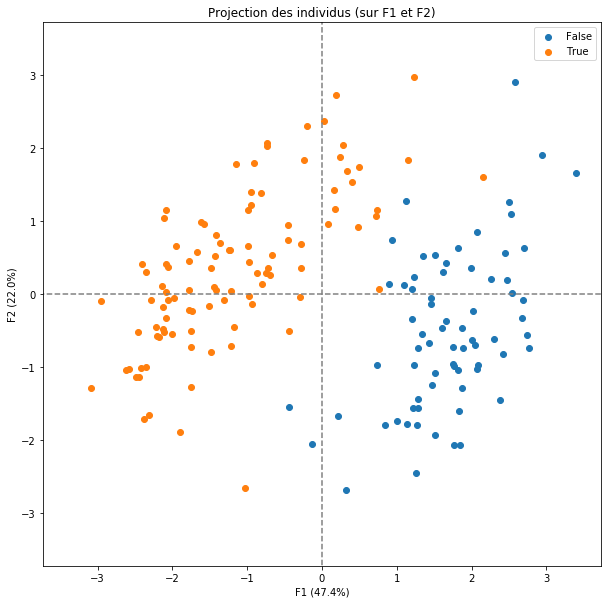

In [158]:
# choix du nombre de composantes à calculer
n_comp = 6


# selection des colonnes à prendre en compte dans l'ACP
data_pca = billets

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = billets.index # ou data.index pour avoir les intitulés
features = billets.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],  illustrative_var=billets.index)

plt.show()

# Analyse de la contribution des individus sur nos 6 variables initiales

In [159]:
X=billets.values
#Récupération des valeurs
#Centrage-réduction des données
std_scaler=preprocessing.StandardScaler()
std_scaler.fit(X)
X_scaled=std_scaler.transform(X)

In [160]:
# Contribution de chaque individu dans l'inertie
# X_scaled contient pour chaque individu, les valeurs de chaque variable, ramenées à une moyenne de 0
# donc pour toutes les valeurs nous donne (carré des différences)
# la somme, pour chaque individu, des carrés des erreurs (=diff a la moyenne/distance par rapport au centre)
contrib_inertie=pd.DataFrame({'contrib':np.sum(X_scaled**2,axis=1)})

In [161]:
# Ajouter la moyenne totale de toutes les variables, afin de pouvoir comparer les moyennes de chaque cluster par rapport au moyenne de l'échantillon total
#Ce sont les points dont la contribution est supérieure à la moyenne qui permettent de donner un sens à l’axe.
contrib_inertie[(contrib_inertie >= contrib_inertie.mean()).all(axis=1)]

,contrib
0,18.410598
4,18.039567
5,11.527985
6,8.029025
7,9.344338
10,6.925087
15,9.071217
18,7.667110
21,6.020373
23,6.233965


# Analyse de la contribution des individus sur le premier plan factoriel

In [162]:
carres_distance=X_projected**2
for j in range(X.shape[1]):
    carres_distance[:,j]=carres_distance[:,j]/contrib_inertie.contrib.values

In [163]:
# Qualité de représentation   
quality_rep=pd.DataFrame({'F1':carres_distance[:,0],
                         'F2':carres_distance[:,1],})
quality_rep['quality']=quality_rep.sum(axis=1)
quality_rep.loc['Mean'] = quality_rep.mean()
quality_rep

,F1,F2,quality
0,0.251929,0.139000,0.390929
1,0.818002,0.050822,0.868824
2,0.784862,0.000466,0.785329
3,0.882856,0.001652,0.884508
4,0.320145,0.009417,0.329562
5,0.132447,0.771985,0.904432
6,0.538540,0.164137,0.702677
7,0.736813,0.115779,0.852592
8,0.505695,0.008692,0.514386
9,0.222965,0.476836,0.699802


# Mission n°2

# Méthode k-mean

In [164]:
# Pour la classificatoon hiérarchique, méthode k-mean et méthode du P5
# et réaliser des matrices de confusion pour voir quelle est la meilleure classification

In [165]:
#Cluster K-means
model=KMeans(n_clusters=2)
#adapter le modèle de données
model.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [166]:
print(model.labels_)

[0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [167]:
billets_c=billets.copy()
billets_c['cluster']=model.labels_ # on ajoute le cluster à notre table
billets_c.head()

,length,height_left,height_right,margin_low,margin_up,diagonal,cluster
is_genuine,,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83,0
True,171.67,103.74,103.70,4.01,2.87,113.29,1
True,171.83,103.76,103.76,4.40,2.88,113.84,1
True,171.80,103.78,103.65,3.73,3.12,113.63,1
True,172.05,103.70,103.75,5.04,2.27,113.55,1


In [169]:
np.where(billets_c.cluster==0)

(array([  0,   5,   9,  10,  65,  69,  84,  96, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
        118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169]),)

In [170]:
np.where(billets_c.index==True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)

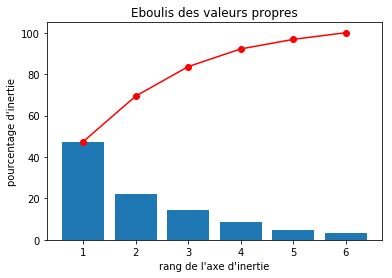

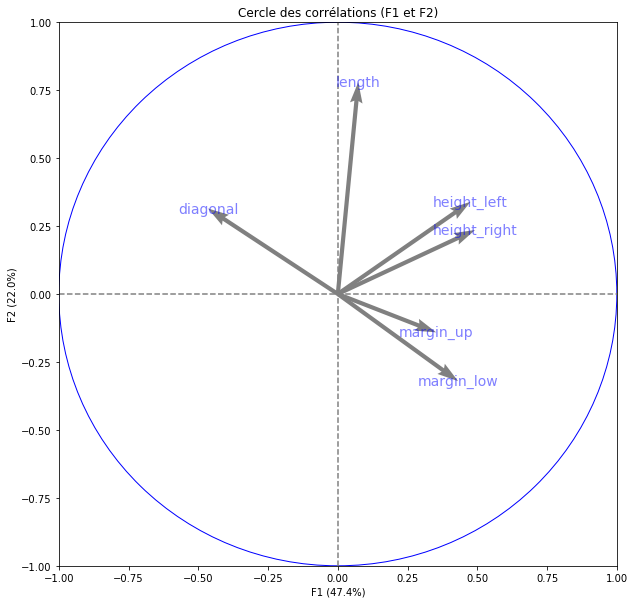

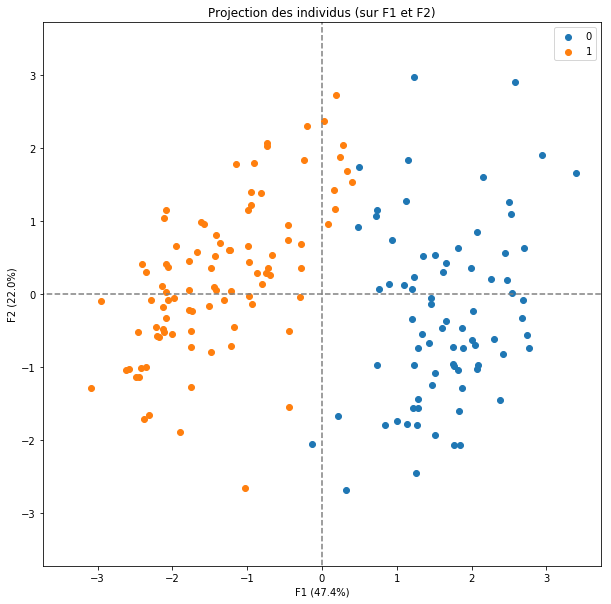

In [171]:
# choix du nombre de composantes à calculer
n_comp = 6


# selection des colonnes à prendre en compte dans l'ACP
data_pca = billets_c.drop(columns=['cluster'])

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = billets_c.index # ou data.index pour avoir les intitulés
features = billets_c.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],  illustrative_var=billets_c.cluster)

plt.show()

In [172]:
# on calcule les centroïdes
length=billets_c.groupby(['cluster'])['length'].mean().reset_index()
height_l=billets_c.groupby(['cluster'])['height_left'].mean().reset_index()
height_r=billets_c.groupby(['cluster'])['height_right'].mean().reset_index()
margin_low=billets_c.groupby(['cluster'])['margin_low'].mean().reset_index()
margin_up=billets_c.groupby(['cluster'])['margin_up'].mean().reset_index()
diago=billets_c.groupby(['cluster'])['diagonal'].mean().reset_index()

In [173]:
# on crée la table de carectérisation selon la moyenne de chaque cluster
df_caracterisation=pd.merge(height_l,length,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,height_r,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,margin_low,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,margin_up,on='cluster')
df_caracterisation=pd.merge(df_caracterisation,diago,on='cluster')
df_caracterisation=df_caracterisation.set_index('cluster')
df_caracterisation.loc['Mean'] = df_caracterisation.mean() # Ajouter la moyenne totale de toutes les variables, afin de pouvoir comparer les moyennes de chaque cluster par rapport au moyenne de l'échantillon total
round(df_caracterisation, 2)

,height_left,length,height_right,margin_low,margin_up,diagonal
cluster,,,,,,
0,104.26,171.92,104.17,5.18,3.32,111.76
1,103.91,171.96,103.73,4.14,3.05,113.24
Mean,104.08,171.94,103.95,4.66,3.18,112.50


# Méthode linkage Ward

In [174]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
clusters = fcluster(Z, 2, criterion='maxclust')
# la plus forte perte d'inertie inter-classe
billets_h=billets.copy()
billets_h['cluster']=clusters # on ajoute le cluster à notre table
billets_h.head()

,length,height_left,height_right,margin_low,margin_up,diagonal,cluster
is_genuine,,,,,,,
True,171.81,104.86,104.95,4.52,2.89,112.83,1
True,171.67,103.74,103.70,4.01,2.87,113.29,2
True,171.83,103.76,103.76,4.40,2.88,113.84,2
True,171.80,103.78,103.65,3.73,3.12,113.63,2
True,172.05,103.70,103.75,5.04,2.27,113.55,2


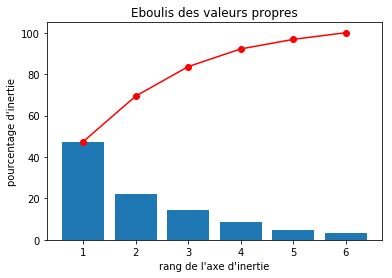

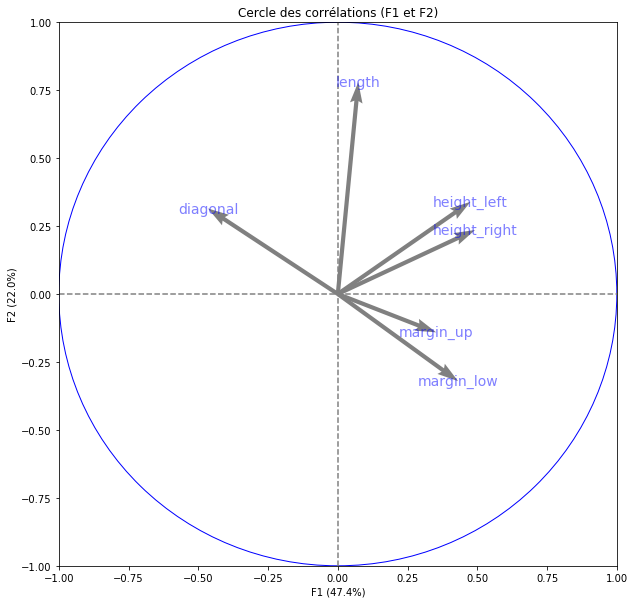

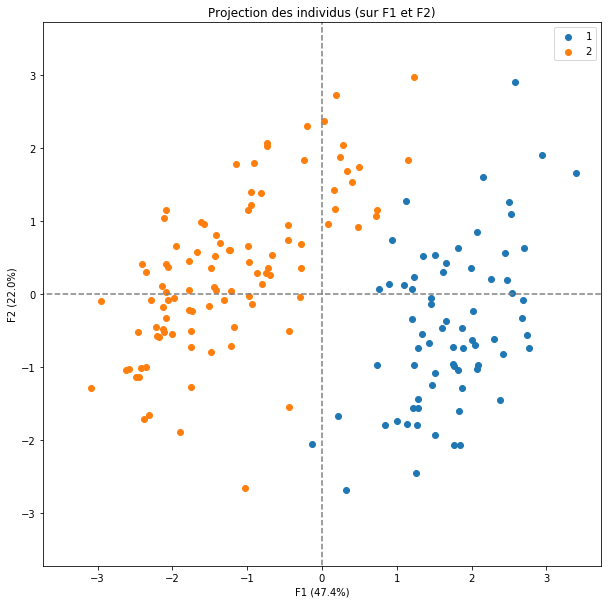

In [175]:
# choix du nombre de composantes à calculer
n_comp = 6


# selection des colonnes à prendre en compte dans l'ACP
data_pca = billets_h.drop(columns=['cluster'])

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = billets_h.index # ou data.index pour avoir les intitulés
features = billets_h.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)],  illustrative_var=billets_h.cluster)

plt.show()

# Mission n°3 

# Régression logistique

In [176]:
billets_lr=pd.read_csv('billets.csv', sep=',')
cols = ['length','height_left','height_right','margin_low','margin_up','diagonal'] 
X = billets_lr[cols] # variables qui vont permettre d'identifier
y = billets_lr['is_genuine'] # si le billet est vrai ou pas 

In [177]:
#We make training and test sets to make sure that after we train our classification algorithm,
# it is able to generalize well to new data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimal number of features: 6
Selected features: ['length', 'height_left', 'height_right', 'margin_low', 'margin_up', 'diagonal']


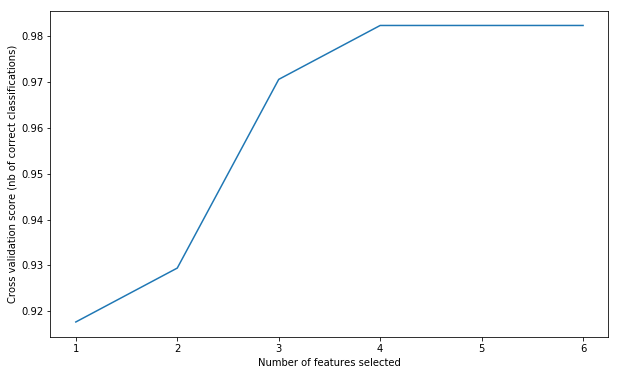

In [178]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [179]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [180]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[23  0]
 [ 0 28]]


# Algorithme de vérification des billets

In [181]:
def certif_billets(csv):
    billeto=pd.read_csv(csv) # on commence par lire le fichier de billets à certifier
    billeto_id=billeto['id'] # on sépare l'id pour l'output
    billeto_val=billeto.loc[:,'length':'diagonal'].values # on selectionne ici les valeurs pour authentifier
    predictions=model.predict_proba(billeto_val) # on regarde ici la probabilité d'être vrai
    for i in range(len(billeto)):
        authentif='vrai' # on ajoute la boucle qui donnera la valeur écrite si le billet est vrai ou faux
        if (round(predictions[i,0],3)) > 0.5:
            authentif='vrai'
        else:
            authentif='faux'
        print("Le billet {} a une probabilité {} d'être vrai, il est donc considéré comme {}".format(billeto_id[i],(round(predictions[i,0],3)),authentif))
        

In [182]:
certif_billets('exemple.csv')

Le billet B_1 a une probabilité 0.942 d'être vrai, il est donc considéré comme vrai
Le billet B_2 a une probabilité 0.984 d'être vrai, il est donc considéré comme vrai
Le billet B_3 a une probabilité 0.96 d'être vrai, il est donc considéré comme vrai
Le billet B_4 a une probabilité 0.139 d'être vrai, il est donc considéré comme faux
Le billet B_5 a une probabilité 0.006 d'être vrai, il est donc considéré comme faux
